In [26]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

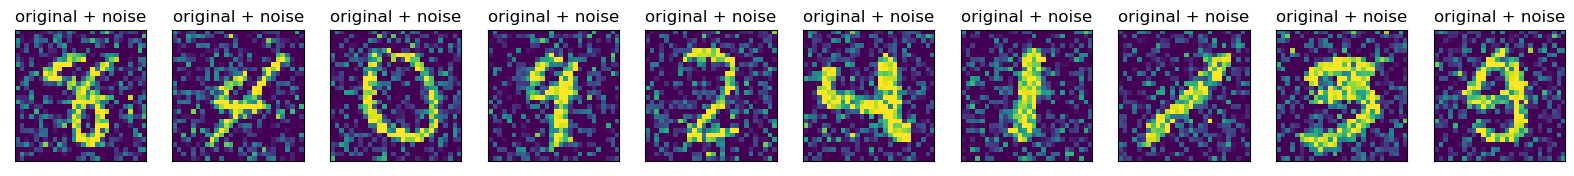

In [27]:
tf.keras.backend.clear_session()

# working pipeline but whack
(train_ds, val_ds) = tfds.load("mnist", split=["train", "test"], as_supervised=True)

noise_intensity = 0.3
batch_size = 64

def preprocess_data(data):
  data = data.map(lambda x, t: (tf.cast(x, tf.float32)/255.), num_parallel_calls=tf.data.AUTOTUNE)
  noisy_data = data.map(lambda x: tf.clip_by_value(x + tf.random.normal(data.element_spec.shape, mean = 0., stddev = noise_intensity), 0, 1), num_parallel_calls=tf.data.AUTOTUNE)
  data = tf.data.Dataset.zip((noisy_data, data))
  data = data.shuffle(1000).cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
  return data

train_ds, val_ds = preprocess_data(train_ds), preprocess_data(val_ds)

for x, y in train_ds.take(1):  # only take first element of dataset
    x_train_noisy = x.numpy()
    x_train = y.numpy()

for x, y in val_ds.take(1):  # only take first element of dataset
    x_test_noisy = x.numpy()
    x_test = y.numpy()

# plot noisy images
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_train_noisy[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [28]:
class CAE(tf.keras.Model):
  def __init__(self):
    super(CAE, self).__init__()
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(28, 28, 1)),
      tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2),
      tf.keras.layers.Conv2D(4, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Conv2DTranspose(4, kernel_size=3, strides=2, activation='relu', padding='same'),
      tf.keras.layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      tf.keras.layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  @tf.function
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [29]:
autoencoder = CAE()

autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

autoencoder.fit(train_ds, 
                epochs=10,
                shuffle=True,
                validation_data=val_ds)

Epoch 1/10
938/938 [==============================] - 13s 13ms/step - loss: 0.0477 - val_loss: 0.0109
Epoch 2/10
938/938 [==============================] - 9s 10ms/step - loss: 0.0093 - val_loss: 0.0082
Epoch 3/10
938/938 [==============================] - 9s 10ms/step - loss: 0.0081 - val_loss: 0.0077
Epoch 4/10
938/938 [==============================] - 9s 10ms/step - loss: 0.0078 - val_loss: 0.0075
Epoch 5/10
938/938 [==============================] - 9s 10ms/step - loss: 0.0076 - val_loss: 0.0074
Epoch 6/10
938/938 [==============================] - 9s 10ms/step - loss: 0.0075 - val_loss: 0.0073
Epoch 7/10
938/938 [==============================] - 9s 10ms/step - loss: 0.0074 - val_loss: 0.0072
Epoch 8/10
938/938 [==============================] - 9s 10ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/10
938/938 [==============================] - 9s 10ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 10/10
938/938 [==============================] - 10s 10ms/step - loss: 0.0072 - val_

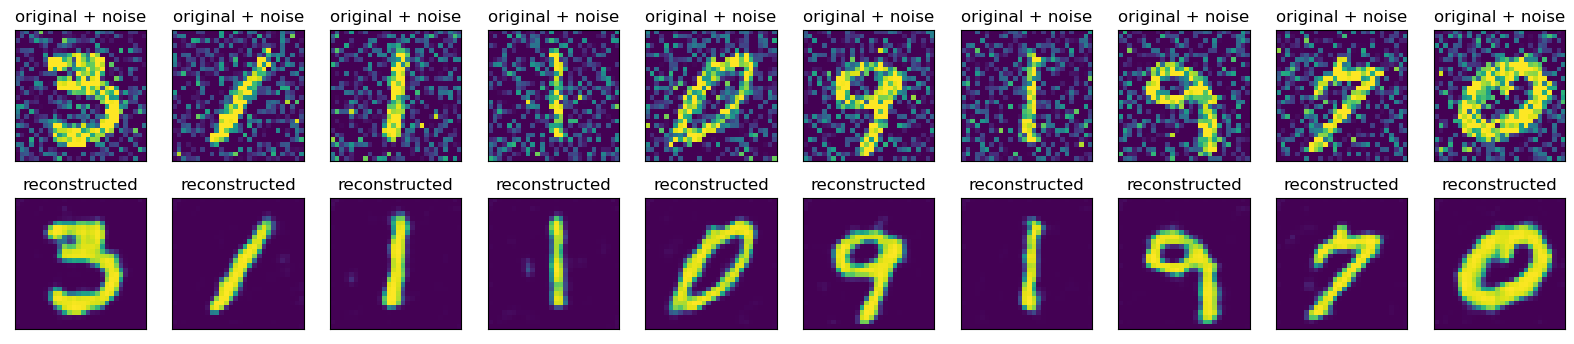

In [30]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

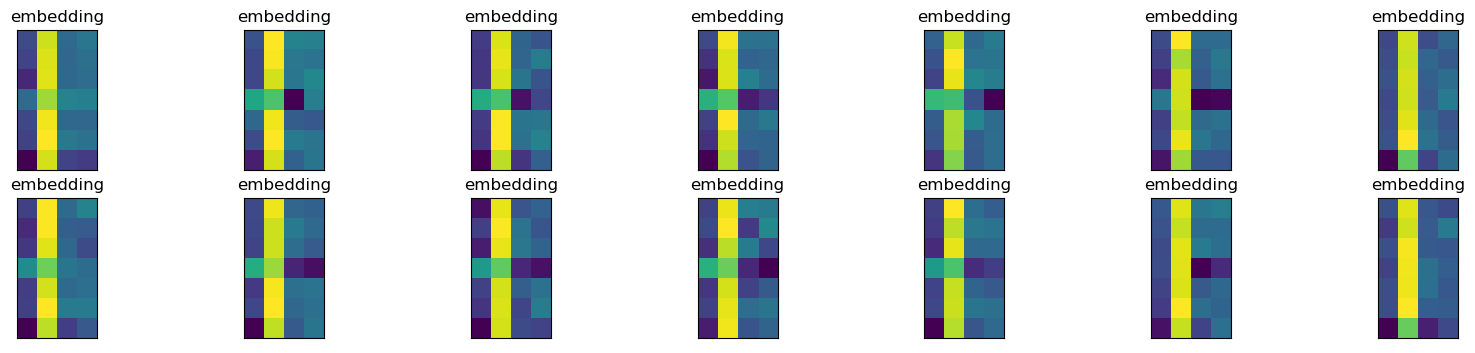

In [32]:
# plotting em
plt.figure(figsize=(20, 4))
n = 7
for i in range(n):
  ax = plt.subplot(2, n, i + 1)
  plt.title("embedding")
  plt.imshow(tf.squeeze(encoded_imgs[6][:][:][i]))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  bx = plt.subplot(2, n, i + n + 1)
  plt.title("embedding")
  plt.imshow(tf.squeeze(encoded_imgs[3][:][:][i]))
  bx.get_xaxis().set_visible(False)
  bx.get_yaxis().set_visible(False)
  
plt.show()